In [75]:
import numpy as np
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import pandas as pd
import matplotlib.pyplot as plt

In [76]:
# Load mnist dataset from keras and divide it in test and traiun dataset
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

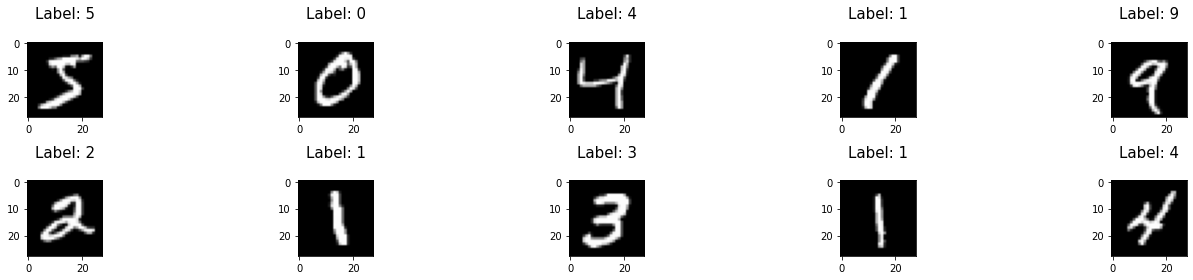

In [77]:
# plot first few images
plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(2, 5, i+1 )
    plt.imshow(x_train[i], cmap=plt.cm.gray)
    plt.title(f'Label: {y_train[i]}\n', fontsize = 15)
plt.tight_layout()

### The purpose of the train and test sets - Test dataset is used to train the classification model and the test set is then be used to test the accuracy of the train classification model.

In [78]:
# Reshape the train and test datasets containing independent variables from 3d to 2d shape to feed in the sklearn classification model 
x_train = x_train.reshape((x_train.shape[0], 784))
x_test = x_test.reshape((x_test.shape[0], 784))

###  Random Forest model

In [80]:
%%time
# Create random forest model
forest = RandomForestClassifier(n_estimators=100, random_state=1)
forest.fit(x_train, y_train)
y_pred = forest.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Calculate features importance
feature_imp = pd.Series(forest.feature_importances_).sort_values(ascending=False)
feature_imp

Accuracy: 0.9699
Wall time: 39.3 s


377    0.008829
433    0.008590
350    0.007783
405    0.007564
378    0.007530
         ...   
281    0.000000
308    0.000000
336    0.000000
337    0.000000
783    0.000000
Length: 784, dtype: float64

In [81]:
%%time
# select important features
X_train = x_train[:,:663]
X_test = x_test[:,:663]

# retrain random forest model
forest = RandomForestClassifier(n_estimators=100, random_state=1)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
random_forest_score = forest.score(X_test, y_test)
print("Random forest:", random_forest_score)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Random forest: 0.97
Accuracy: 0.97
Wall time: 36.8 s


### n_estimators, which defines the numbers of trees in the forest modea is selected to tune the model. Higher number of trees give better performance but makes the code slower. Optimum value of n_estimators provides efficient model with stronger and stable predictions for the capacity of the processor.

### In addition to this, criterion parameter is selected which is the function to measure the quality of a split.

In [83]:
%%time
from sklearn.model_selection import GridSearchCV
parameters = [{'n_estimators': [10, 50, 100, 150, 200], 'criterion' : ["gini"]},
              {'n_estimators': [10, 50, 100, 150, 200], 'criterion' : ["entropy"]},
              {'n_estimators': [10, 50, 100, 150, 200], 'criterion' : ["log_loss"]}]

grid_search = GridSearchCV(estimator=forest, param_grid=parameters, scoring='accuracy', cv=10, n_jobs= -1)
grid_search = grid_search.fit(X_train, y_train)

Wall time: 13min 10s


In [84]:
accuracy = grid_search.best_score_
accuracy

0.9685333333333335

In [85]:
# Get the optimum values of n_estimators and criterion
grid_search.best_params_

{'criterion': 'gini', 'n_estimators': 150}

### Based on the outcome of GridSearchCV above, 'gini' critetian and 150 value of 'n_estimatoes' is used below to retain the model.

In [86]:
# retrain the random forest model using optinum values of n_estimators and criterion
forest = RandomForestClassifier(n_estimators=150, criterion='gini', random_state=1)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
random_forest_score = forest.score(X_test, y_test)
print("Random forest:", random_forest_score)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Random forest: 0.9705
Accuracy: 0.9705


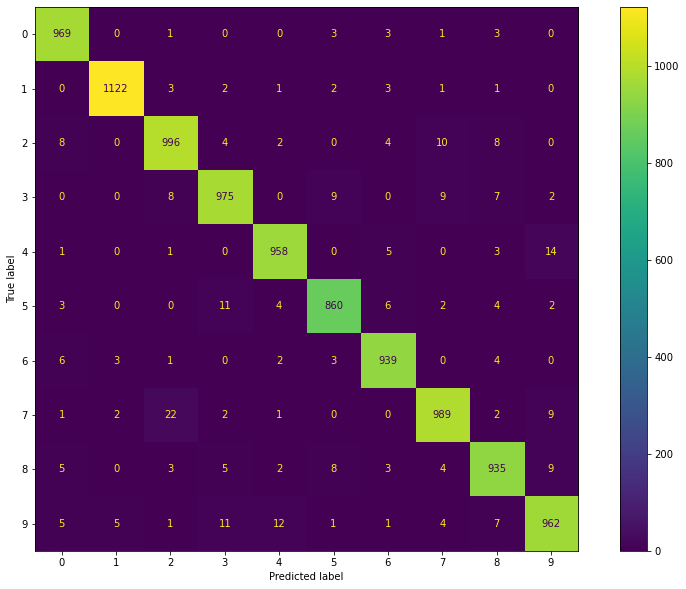

In [87]:
# Making the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(15,10))
disp.plot(ax=ax)

In [88]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9709    0.9888    0.9798       980
           1     0.9912    0.9885    0.9899      1135
           2     0.9614    0.9651    0.9632      1032
           3     0.9653    0.9653    0.9653      1010
           4     0.9756    0.9756    0.9756       982
           5     0.9707    0.9641    0.9674       892
           6     0.9741    0.9802    0.9771       958
           7     0.9696    0.9621    0.9658      1028
           8     0.9600    0.9600    0.9600       974
           9     0.9639    0.9534    0.9586      1009

    accuracy                         0.9705     10000
   macro avg     0.9703    0.9703    0.9703     10000
weighted avg     0.9705    0.9705    0.9705     10000



### From the f1-scores of the classes in the classification report above, it seems, class 9 has the lowest f1-score hence it can be said that the model struggles with class 9 the most.  